In [3]:
import os
import cv2
import numpy as np
import pandas as pd

# Neural Network PyTorch
import torch
import torch.nn as nn
import torch.backends.cudnn
import torch.nn.functional as F

# Neural Network PyTorch Datasets
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn import linear_model
from sklearn.model_selection import train_test_split 

from mpl_toolkits.mplot3d import axes3d 
import matplotlib.pyplot as plt
from matplotlib import style

style.use('seaborn')
%config InlineBackend.figure_format = 'retina'

In [4]:
torch.manual_seed(1)  # for reproducibility
device = None
if torch.cuda.is_available():
    # inbuilt cudnn auto-tuner searches for best algorithm for hardware
    # cuddn.benchmark should be set to True when our input size does not vary
    torch.backends.cudnn.benchmark = True
    print("GPU training available")
    device = torch.device("cuda:0")
    print(f"Index of CUDA device in use is {torch.cuda.current_device()}")
else:
    print("GPU training NOT available")
    device = torch.device("cpu")
    print("Can only train on CPU")

GPU training NOT available
Can only train on CPU


**After running hyper-optimization**

Evaluation of best performing model: [0.08686549411728861, 0.17438459396362305]
Best performing model chosen hyper-parameters:
{'Dense': 4, 'Dense_1': 'four', 'batch_size': 1024, 'optimizer': 'rmsprop'}

In [3]:
class Standardizer:
    def __init__(self):
        self.means = None
        self.stds = None

    def fit(self, X):
        self.means = X.mean(axis=0)
        self.stds = X.std(axis=0)

    def transform(self, X):
        if self.means is None or self.stds is None:
            raise ValueError("Standardizer has not been fitted")
        return (X - self.means) / self.stds


class HyperParameter:
    def __init__(self,
                 epochs=20,
                 lr=0.001,
                 betas=(0.9, 0.999),
                 weight_decay=0):
        self.epochs = epochs
        self.lr = lr
        self.betas = betas
        self.weight_decay = weight_decay

    def __repr__(self):
        return f"Epochs: {self.epochs}\n" +\
               f"Learning rate: {self.lr}\n" +\
               f"Betas: {self.betas}\n" +\
               f"Weight Decay: {self.weight_decay}\n"


class RMSELogLoss(nn.Module):

    def __init__(self, **kwargs):
        super().__init__()
        self.mse = nn.MSELoss(**kwargs)

    def forward(self, y_hat, y):
        return torch.sqrt(self.mse(torch.log(y_hat), torch.log(y)))


class RMSELoss(nn.Module):

    def __init__(self, **kwargs):
        super().__init__()
        self.mse = nn.MSELoss(**kwargs)

    def forward(self, y_hat, y):
        return torch.sqrt(self.mse(y_hat, y))


def SqrRelDiff(output, target):
    """
    Squared Relative Difference Loss
    """
    if len(output) != len(target):
        raise ValueError(
            f"output size {output.shape} and target size {target.shape} mismatch")
    loss = ((output - target)**2)/target
    return torch.sum(loss) / len(target)


def AbsRelDiff(output, target):
    """
    Absolute Relative Difference Loss
    """
    if len(output) != len(target):
        raise ValueError(
            f"output size {output.shape} and target size {target.shape} mismatch")
    loss = torch.abs((output - target))/target
    return torch.sum(loss) / len(target)

In [4]:
def calculate_loss_across_all_metrics(y_pred, y_true):
    """
    Returns mse_loss, rmse_loss, rmse_log_loss, sqr_rel_diff, abs_rel_diff
    y_pred and y_true must both be torch.Tensors
    """
    mse_loss = nn.MSELoss()
    rmse_loss = RMSELoss()
    rmse_log_loss = RMSELogLoss()
    sqr_rel_diff = SqrRelDiff(y_pred, y_true)
    abs_rel_diff = AbsRelDiff(y_pred, y_true)
    return (mse_loss(y_pred, y_true),
            rmse_loss(y_pred, y_true),
            rmse_log_loss(y_pred, y_true),
            sqr_rel_diff,
            abs_rel_diff)

In [5]:
class DistanceDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        cur_X, cur_y = self.X[idx], self.y[idx]
        if self.transform:
            cur_X = self.transform(cur_X)

        return torch.Tensor(cur_X).float(), torch.Tensor(cur_y).float()

    def __len__(self):
        return len(self.X)

In [6]:
class DistanceRegrNet(torch.nn.Module):
    def __init__(self, input_dim, module_arch=None):
        """
        module_arch: python list specifies the architecture of the module
        """
        super(DistanceRegrNet, self).__init__()

        if module_arch is None:
            module_arch = [input_dim, 6, 4, 2, 1]
        modules = []
        for i in range(len(module_arch[:-1])):
            modules.append(nn.Linear(module_arch[i], module_arch[i + 1]))
            if i < len(module_arch[:-2]):
                modules.append(nn.LeakyReLU())
        modules.append(nn.Softplus())
        self.main = nn.Sequential(*modules)

    def forward(self, X):
        return self.main(X)

In [7]:
class Model:
    def __init__(self,
                 hp,
                 regr_nn=DistanceRegrNet(2),
                 criterion=None,
                 optimizer=None,
                 scheduler=None):
        """
        The reduction for criterion must be set to summmation
        """
        self.hp = hp
        self.regr_nn = regr_nn
        self.loss_train_overtime = []
        self.loss_val_overtime = []

        self.criterion = nn.MSELoss(
            reduction='sum') if criterion is None else criterion

        self.optimizer = torch.optim.Adam(self.regr_nn.parameters(),
                                          lr=self.hp.lr,
                                          betas=self.hp.betas,
                                          weight_decay=self.hp.weight_decay) if optimizer is None else optimizer

        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.1, patience=5, verbose=True) if scheduler is None else scheduler

    def fit(self,
            train_data_loader,
            device,
            val_data_loader=None,
            save_wt_interval=None):

        for epoch in range(self.hp.epochs):
            running_loss_train = 0
            train_count = 0
            for idx, (X_data, y_data) in enumerate(train_data_loader):
                X_data = X_data.to(device)
                y_data = y_data.to(device)

                self.regr_nn.zero_grad()
                y_hat = self.regr_nn(X_data)  # feedforward
                loss = self.criterion(y_hat, y_data)  # cal loss
                loss.backward()  # backpropagation
                self.optimizer.step()  # update weights

                running_loss_train += loss.item()
                if save_wt_interval is not None and idx % save_wt_interval:
                    os.makedirs('distance_regressor/weights', exist_ok=True)
                    torch.save(self.regr_nn.state_dict(),
                               f'distance_regressor/weights/regrNN_epoch_{epoch}_iter_{idx}.pt')
                train_count += X_data.shape[0]

            if val_data_loader is not None:
                running_loss_val = 0
                val_count = 0
                for X_val_data, y_val_data in val_data_loader:
                    val_count += X_val_data.shape[0]
                    y_val_hat = self.regr_nn(X_val_data.to(device))
                    running_loss_val += self.criterion(y_val_hat,
                                                       y_val_data.to(device))

                # RMSE and RMSE log have the sqrt term
                if isinstance(self.criterion, RMSELoss) or isinstance(self.criterion, RMSELogLoss):
                    val_count = val_count ** (1/2)
                avg_val_loss = running_loss_val / val_count
                print(
                    f"Avg Validation loss at epoch {epoch} is {avg_val_loss}")
                self.loss_val_overtime.append(avg_val_loss)
                self.scheduler.step(running_loss_val)

            if isinstance(self.criterion, RMSELoss) or isinstance(self.criterion, RMSELogLoss):
                train_count = train_count ** (1/2)
            avg_loss_train = running_loss_train / train_count
            self.loss_train_overtime.append(avg_loss_train)
            print(f"Avg Train loss at epoch {epoch} is {avg_loss_train}")

    def predict(self, x):
        return self.regr_nn(x)

    @staticmethod
    def line_plot(loss1,
                  loss2=None,
                  labels=None,
                  title='MSE Loss overtime',
                  save_fig_path=None):
        """
        labels is list of labels
        """
        if labels is None:
            labels = ['loss1']

        plt.figure(figsize=(12, 8))
        plt.title(title)
        plt.xlabel("Epochs", fontsize=15)
        plt.ylabel("loss", fontsize=15)

        plt.plot(loss1, label=labels[0])
        if loss2 is not None:
            plt.plot(loss2, label=labels[1])
        plt.legend(fontsize=20)
        plt.show()

        if save_fig_path is not None:
            plt.savefig(save_fig_path)

    def plot_loss(self, title='MSE Loss overtime'):
        Model.line_plot(self.loss_train_overtime, self.loss_val_overtime,
                        ['Train loss', 'Val loss'], title=title)

    def save_model(self, save_path):
        torch.save(self.regr_nn.state_dict(), save_path)

    def load_model(self, load_path):
        self.regr_nn.load_state_dict(torch.load(load_path))

## Exploring the training data

### Load annotations.csv data

In [9]:
data_k = pd.read_csv("./SSD_active_crowd_analysis/distance_regressor/data/annotations.csv")
data_k.groupby('class')['class'].count()

class
Car               28742
Cyclist            1627
Misc                973
Pedestrian         4487
Person_sitting      222
Tram                511
Truck              1094
Van                2914
Name: class, dtype: int64

In [10]:
data_k.head()

filename       class  truncated  occluded  observation angle    xmin  \
0  000000.txt  Pedestrian        0.0         0              -0.20  712.40   
1  000001.txt       Truck        0.0         0              -1.57  599.41   
2  000001.txt         Car        0.0         0               1.85  387.63   
3  000001.txt     Cyclist        0.0         3              -1.65  676.60   
4  000002.txt        Misc        0.0         0              -1.82  804.79   

     ymin    xmax    ymax  height  width  length   xloc  yloc   zloc  rot_y  
0  143.00  810.73  307.92    1.89   0.48    1.20   1.84  1.47   8.41   0.01  
1  156.40  629.75  189.25    2.85   2.63   12.34   0.47  1.49  69.44  -1.56  
2  181.54  423.81  203.12    1.67   1.87    3.69 -16.53  2.39  58.49   1.57  
3  163.95  688.98  193.93    1.86   0.60    2.02   4.59  1.32  45.84  -1.55  
4  167.34  995.43  327.94    1.63   1.48    2.37   3.23  1.59   8.55  -1.47

### Distribution of distances

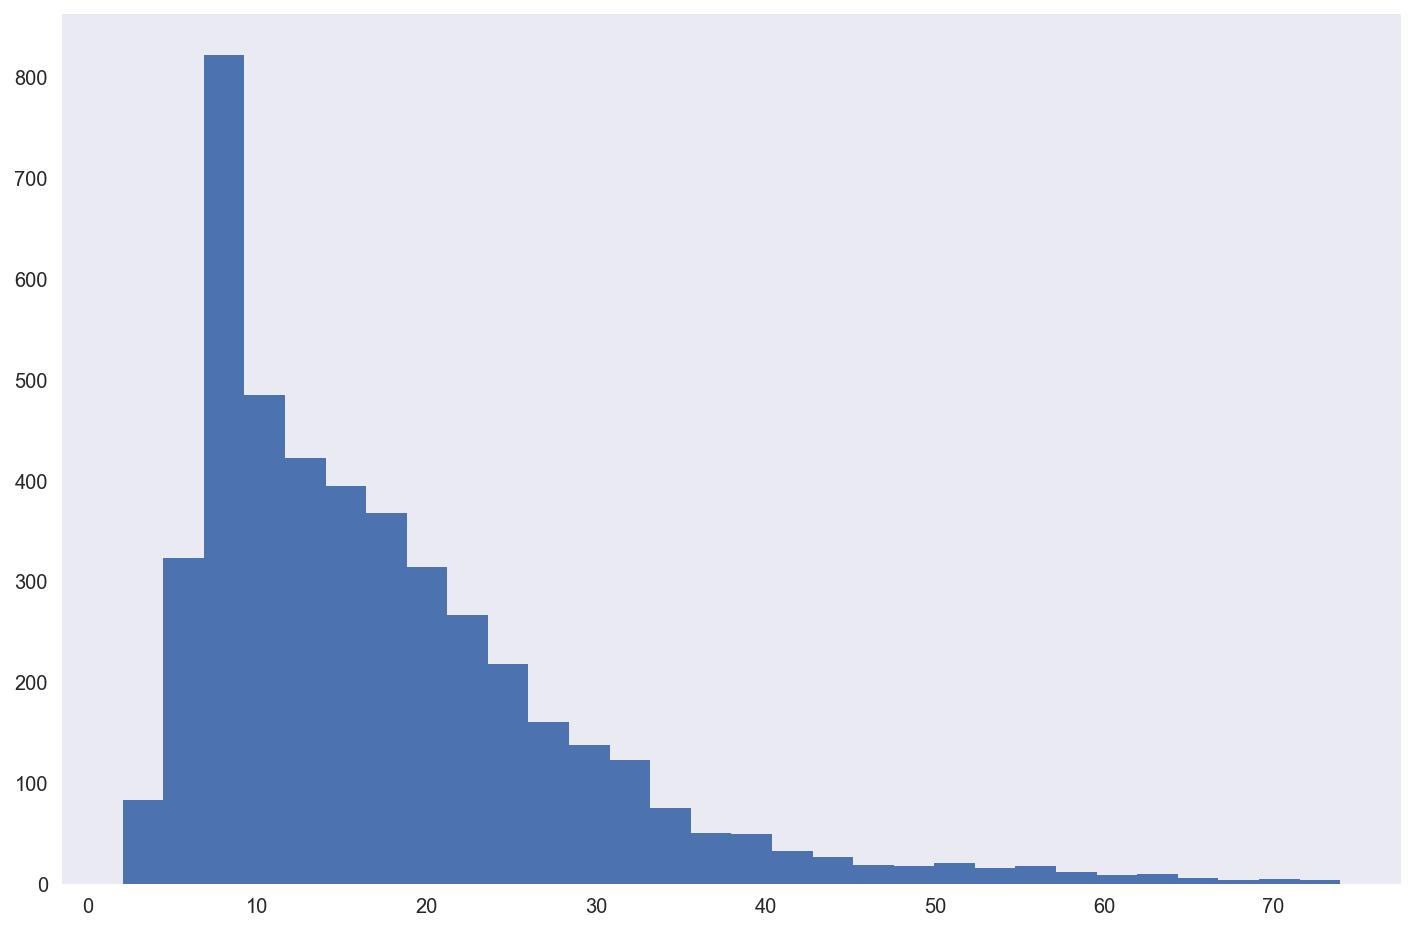

In [11]:
ped_data = data_k[data_k['class']=='Pedestrian']
ped_data['zloc'].hist(figsize=(12,8), bins=30, grid=False)

In [12]:
def plot_bbox_wh_3d(df,
                    pclasses=None,
                    colors=None,
                    size=1):
    """
    df DataFrame must have columns ['class', 'xmin', 'ymin', 'xmax', 'ymax', 'zloc']
    where 'xmin', 'ymin', 'xmax', 'ymax' represent the bounding box coordinates
    and zloc represents the distance to the object from the camera
    """
    if pclasses is None:
        pclasses = ['Pedestrian', 'Cyclist', 'Person_sitting']
    if colors is None:
        colors = ['red', 'green', 'blue']
    
    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection='3d')
    ax.set_xlabel('Bounding Box Width', fontsize=10)
    ax.set_ylabel('Bounding Box Height', fontsize=10)
    ax.set_zlabel('Distance to object (Meters)', fontsize=10)

    for i, pclass in enumerate(pclasses):
        df_bh_bw = df[df['class'] == pclass].copy()
        bbox_w = df_bh_bw['xmax'] - df_bh_bw['xmin']
        bbox_h = df_bh_bw['ymax'] - df_bh_bw['ymin']
        bbox_w = bbox_w.to_numpy().reshape(-1, 1)
        bbox_h = bbox_h.to_numpy().reshape(-1, 1)
        obj_dist = df_bh_bw['zloc'].to_numpy().reshape(-1, 1)
        
        xdata, ydata, zdata = bbox_w, bbox_h, obj_dist
        ax.scatter3D(xdata, ydata, zdata, s=size, c=colors[i], label=pclass)
        ax.view_init(30, 60)
        plt.legend(fontsize=15)


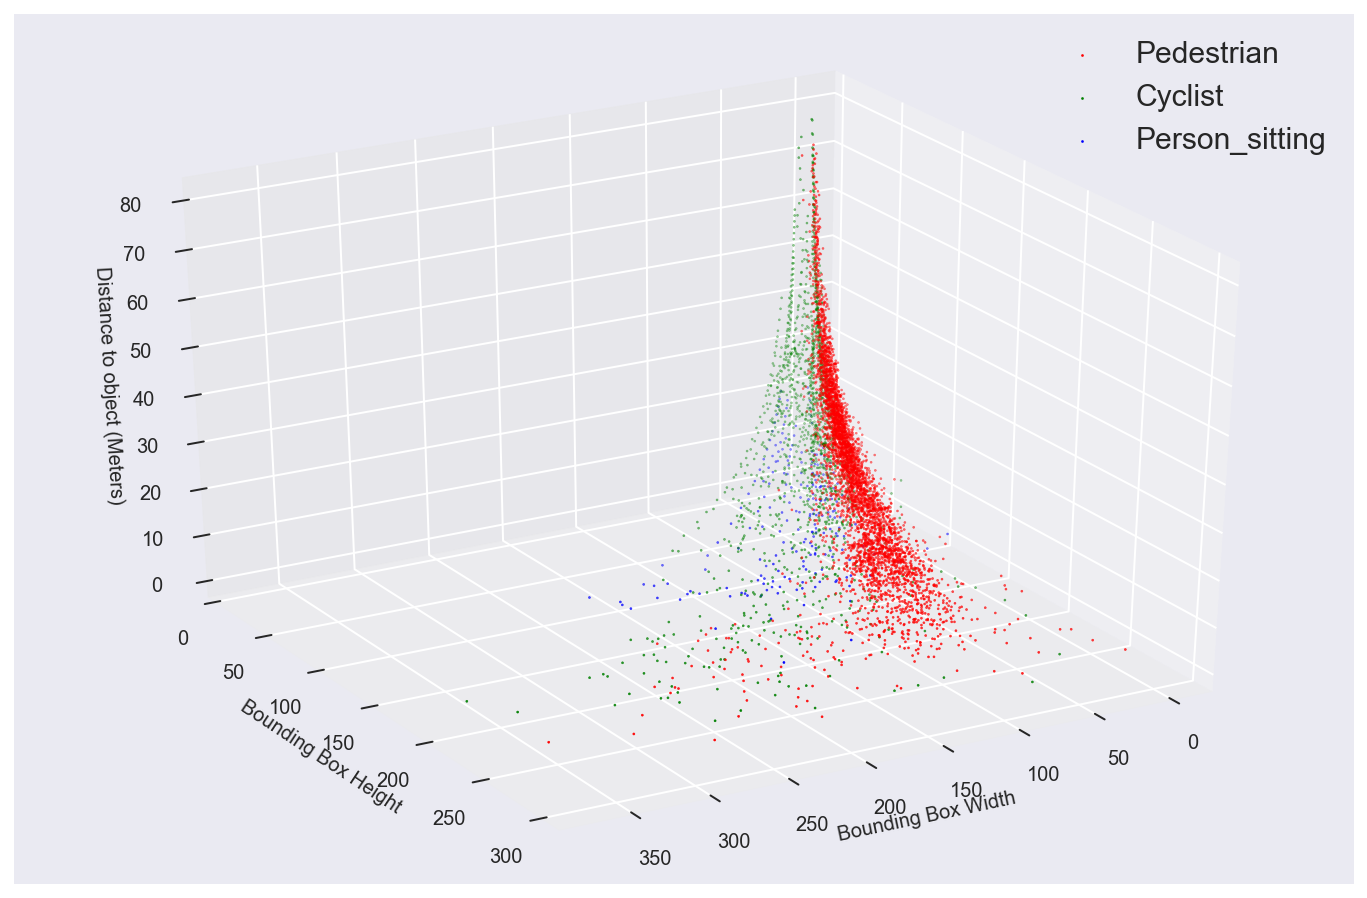

In [13]:
plot_bbox_wh_3d(data_k)

In [14]:
def plot_bbox_wh_2d(df,
                    pclasses=None,
                    colors=None,
                    size=1):
    """
    df DataFrame must have columns ['class', 'xmin', 'ymin', 'xmax', 'ymax']
    where 'xmin', 'ymin', 'xmax', 'ymax' represent the bounding box coordinates
    """
    if pclasses is None:
        pclasses = ['Pedestrian', 'Cyclist', 'Person_sitting']
    if colors is None:
        colors = ['red', 'green', 'blue']
    plt.figure(figsize=(12, 8))
    plt.xlabel('Bounding Box Width', fontsize=15)
    plt.ylabel('Bounding Box Height', fontsize=15)
    plt.grid(False)
    
    for i, pclass in enumerate(pclasses):
        df_bh_bw = df[df['class'] == pclass].copy()
        bbox_w = df_bh_bw['xmax'] - df_bh_bw['xmin']
        bbox_h = df_bh_bw['ymax'] - df_bh_bw['ymin']
        bbox_w = bbox_w.to_numpy().reshape(-1, 1)
        bbox_h = bbox_h.to_numpy().reshape(-1, 1)

        regr = linear_model.LinearRegression()
        regr.fit(bbox_w, bbox_h)
        plt.plot(bbox_w,
                 regr.predict(bbox_w),
                 color=colors[i],
                 linewidth=1.5,
                 label=pclass)

        plt.legend(fontsize=20)
        plt.scatter(bbox_w, bbox_h, s=size, c=colors[i])

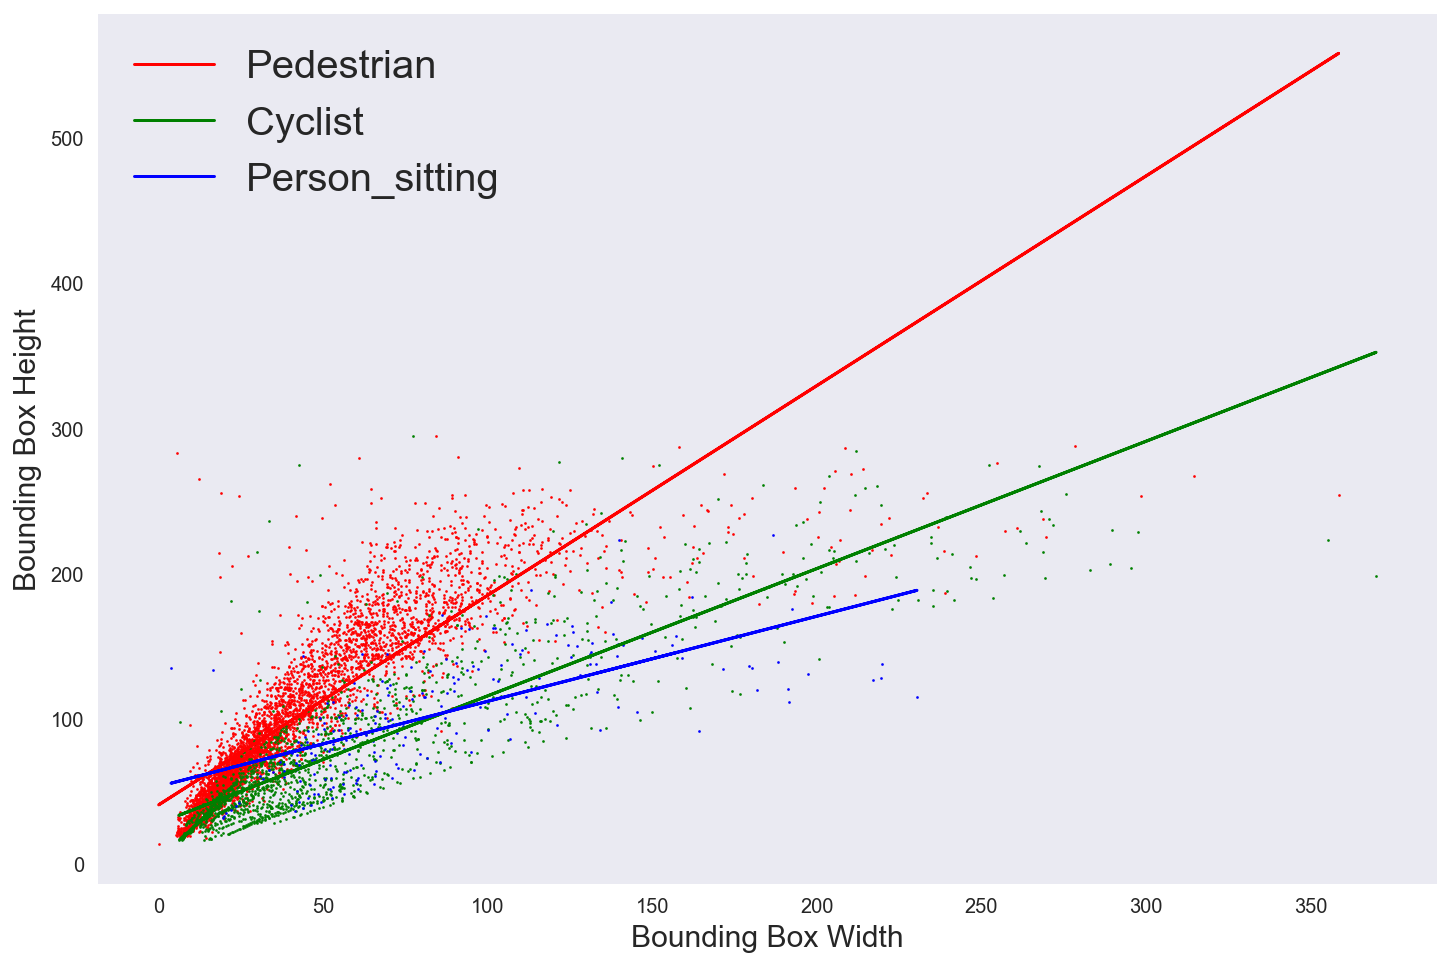

In [15]:
plot_bbox_wh_2d(data_k)

### Investigate images in the KITTI dataset

In [16]:
src_dir = './SSD_active_crowd_analysis/distance_regressor/data'

display_num = 2
display_dict = {
    'Pedestrian': display_num,
    'Cyclist': display_num,
    'Person_sitting': display_num
}
labeled_img_dir = os.path.join(src_dir, 'labeled_images')
os.makedirs(labeled_img_dir, exist_ok=True)

for idx, row in data_k.iterrows():
    if row['class'] in display_dict:
        if os.path.exists(
            os.path.join(src_dir + "/train_images/",
                         row['filename'].replace('.txt', '.png'))):
            
            fp = os.path.join(src_dir + "/train_images/",
                              row['filename'].replace('.txt', '.png'))
            im = cv2.imread(fp)
            display_dict[row['class']] -= 1
            if display_dict[row['class']] == 0:
                del display_dict[row['class']]

            x1 = int(row['xmin'])
            y1 = int(row['ymin'])
            x2 = int(row['xmax'])
            y2 = int(row['ymax'])

            cv2.line(im, (int(1224 / 2), 0), (int(1224 / 2), 370), (255, 255, 255),
                     2)
            cv2.rectangle(im, (x1, y1), (x2, y2), (0, 255, 0), 3)
            string = "({}, {})".format(row['observation angle'], row['zloc'])
            cv2.putText(im, string, (int((x1 + x2) / 2), int((y1 + y2) / 2)),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
            print(f"Writing file {fp}")
            cv2.imwrite(f'./{labeled_img_dir}/{row["class"]}_{idx}.jpg', im)

Writing file ./SSD_active_crowd_analysis/distance_regressor/data/train_images/000001.png
Writing file ./SSD_active_crowd_analysis/distance_regressor/data/train_images/000303.png
Writing file ./SSD_active_crowd_analysis/distance_regressor/data/train_images/000303.png
Writing file ./SSD_active_crowd_analysis/distance_regressor/data/train_images/000341.png
Writing file ./SSD_active_crowd_analysis/distance_regressor/data/train_images/000341.png


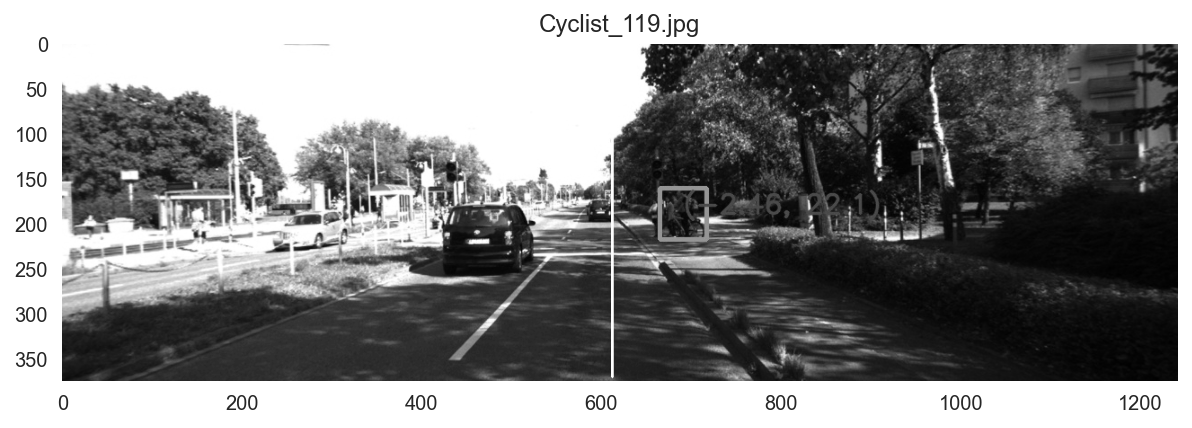

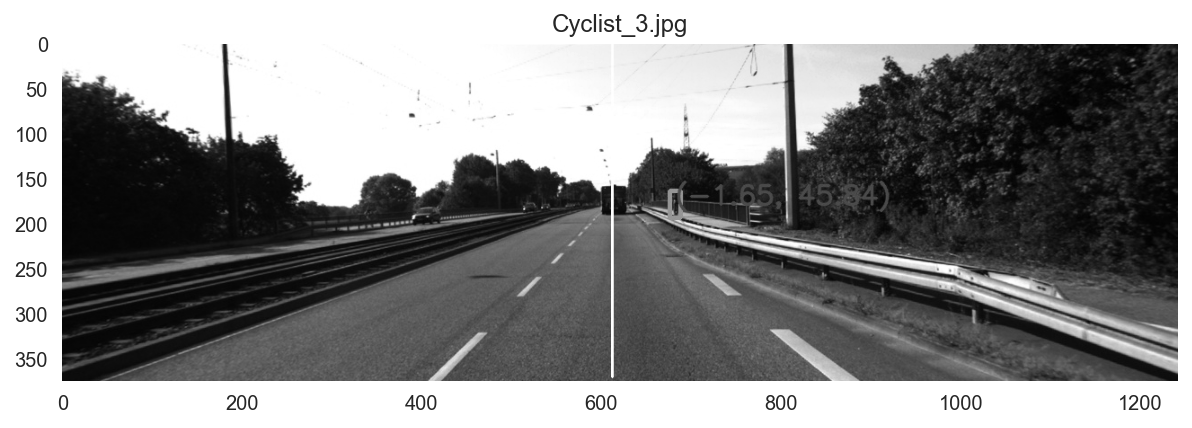

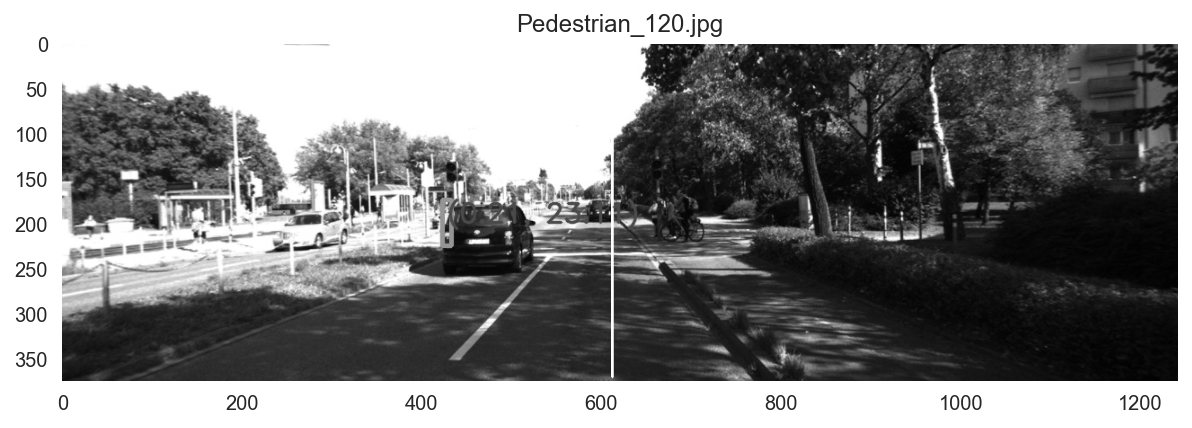

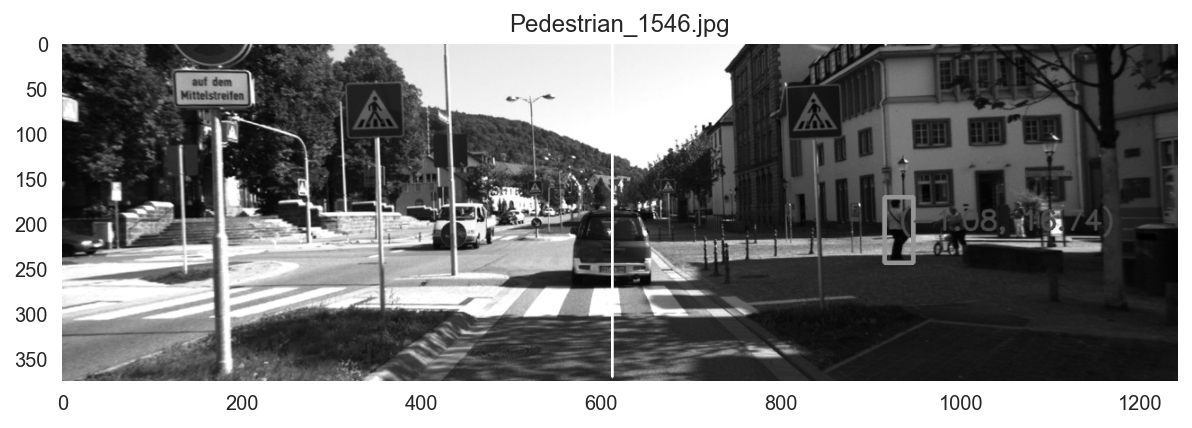

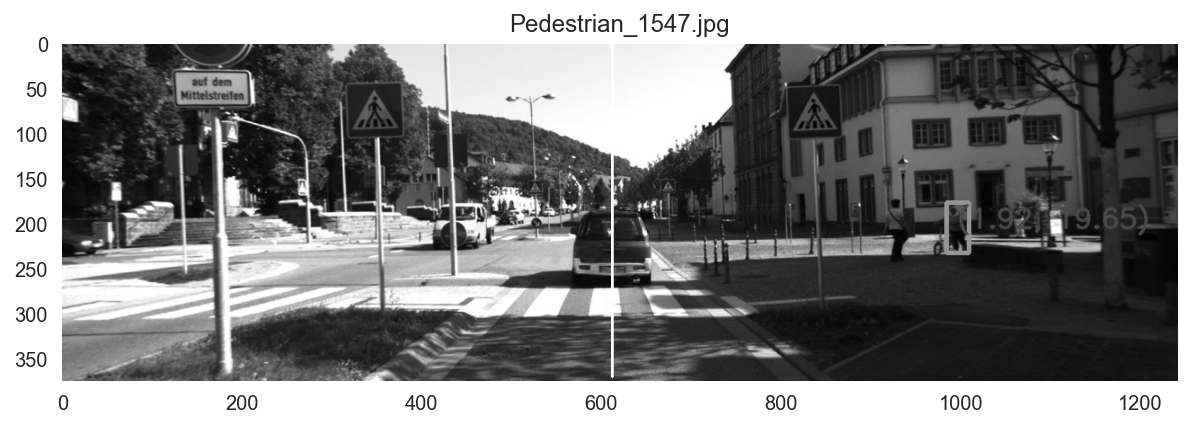

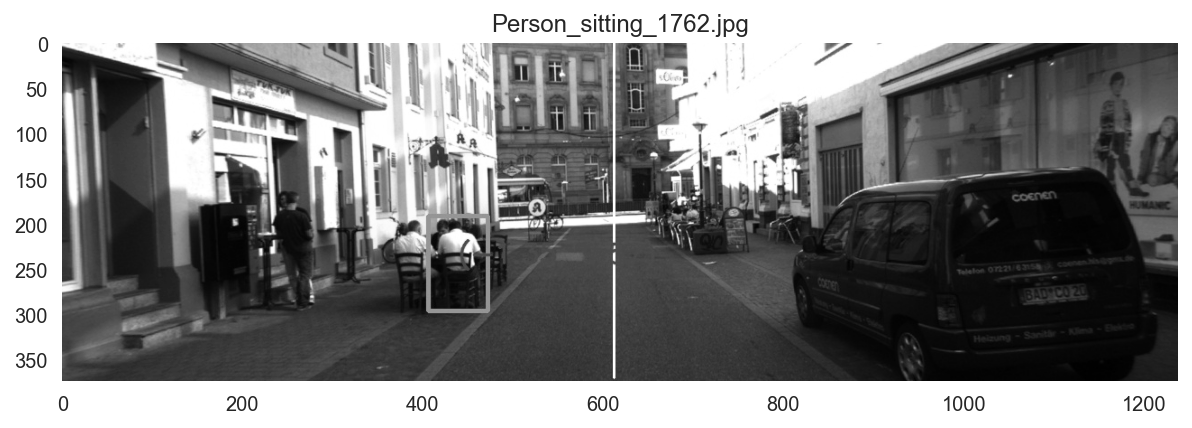

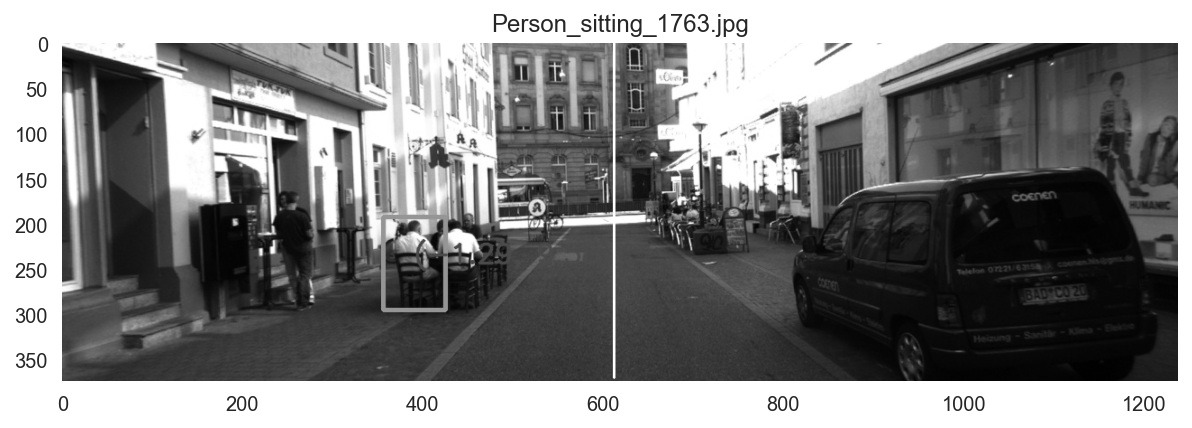

In [48]:
labeled_img_dir_list = sorted(os.listdir(labeled_img_dir))

for img_file in labeled_img_dir_list:
    img = cv2.imread(os.path.join(labeled_img_dir, img_file))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    plt.figure(figsize=(10,8))
    plt.imshow(gray, cmap='gray')
    plt.grid(False)
    plt.title(img_file)
    plt.show();

## For training we will only use the Pedestrian class

### Train Test Split

In [17]:
data_k.head()

filename       class  truncated  occluded  observation angle    xmin  \
0  000000.txt  Pedestrian        0.0         0              -0.20  712.40   
1  000001.txt       Truck        0.0         0              -1.57  599.41   
2  000001.txt         Car        0.0         0               1.85  387.63   
3  000001.txt     Cyclist        0.0         3              -1.65  676.60   
4  000002.txt        Misc        0.0         0              -1.82  804.79   

     ymin    xmax    ymax  height  width  length   xloc  yloc   zloc  rot_y  
0  143.00  810.73  307.92    1.89   0.48    1.20   1.84  1.47   8.41   0.01  
1  156.40  629.75  189.25    2.85   2.63   12.34   0.47  1.49  69.44  -1.56  
2  181.54  423.81  203.12    1.67   1.87    3.69 -16.53  2.39  58.49   1.57  
3  163.95  688.98  193.93    1.86   0.60    2.02   4.59  1.32  45.84  -1.55  
4  167.34  995.43  327.94    1.63   1.48    2.37   3.23  1.59   8.55  -1.47

In [20]:
X_feat = data_k[data_k['class']=='Pedestrian'][['xmin','ymin', 'xmax', 'ymax']]
X_feat['bw'], X_feat['bh'] = X_feat['xmax'] - X_feat['xmin'], X_feat['ymax'] - X_feat['ymin']
X_feat = X_feat[['bw', 'bh']].to_numpy()
y_feat = data_k[data_k['class']=='Pedestrian'][['zloc']].to_numpy()
y_numpy = y_feat.reshape(-1,1)
print(src_dir)

./SSD_active_crowd_analysis/distance_regressor/data


In [21]:
LOAD_SAVED_SPLITS = True

if LOAD_SAVED_SPLITS:
    X_train, X_val, y_train, y_val = (np.load(src_dir+'/train_val/train/X_train.npy'),
                                      np.load(src_dir+'/train_val/val/X_val.npy'),
                                      np.load(src_dir+'/train_val/train/y_train.npy'),
                                      np.load(src_dir+'/train_val/val/y_val.npy'))
else:
    X_train, X_val, y_train, y_val = train_test_split(
        X_feat, y_numpy, test_size=0.2, random_state=1)
    np.save(src_dir+'/train_val/train/X_train.npy', X_train)
    np.save(src_dir+'/train_val/val/X_val.npy', X_val)
    np.save(src_dir+'/train_val/train/y_train.npy', y_train)
    np.save(src_dir+'/train_val/val/y_val.npy', y_val)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(3589, 2) (898, 2) (3589, 1) (898, 1)


### Setting with data loaders

In [22]:
# For reproducibility 
torch.manual_seed(0)

X_train_scaler = Standardizer()
X_train_scaler.fit(X_train)

# Standardize the test and validation sets with the same mean and std from the train data
train_dataset = DistanceDataset(X_train_scaler.transform(X_train), y_train)
val_dataset = DistanceDataset(X_train_scaler.transform(X_val), y_val)

# Creating DataLoaders
train_data_loader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=128,
    num_workers=1,
)
val_data_loader = DataLoader(
    val_dataset,
    shuffle=True,
    batch_size=128,
    num_workers=1,
)

### Regression with MSE loss

In [23]:
hp = HyperParameter(epochs=200)
regr_net_mse = Model(hp, DistanceRegrNet(input_dim=2).to(device))

regr_net_mse.regr_nn.train()
regr_net_mse.fit(train_data_loader, device, val_data_loader)

Avg Validation loss at epoch 0 is 368.6423034667969
Avg Train loss at epoch 0 is 420.4141620881513
Avg Validation loss at epoch 1 is 367.8513488769531
Avg Train loss at epoch 1 is 419.6453486347172
Avg Validation loss at epoch 2 is 366.86138916015625
Avg Train loss at epoch 2 is 418.71096838321085
Avg Validation loss at epoch 3 is 365.5558776855469
Avg Train loss at epoch 3 is 417.5160720582857
Avg Validation loss at epoch 4 is 363.7023010253906
Avg Train loss at epoch 4 is 415.89558539466293
Avg Validation loss at epoch 5 is 360.63812255859375
Avg Train loss at epoch 5 is 413.38434291955457
Avg Validation loss at epoch 6 is 355.291748046875
Avg Train loss at epoch 6 is 409.0005252866833
Avg Validation loss at epoch 7 is 345.3373718261719
Avg Train loss at epoch 7 is 401.16890164064677
Avg Validation loss at epoch 8 is 327.21112060546875
Avg Train loss at epoch 8 is 386.5411655344183
Avg Validation loss at epoch 9 is 298.2651062011719
Avg Train loss at epoch 9 is 360.9975486451386
Avg 

Avg Validation loss at epoch 81 is 12.242643356323242
Avg Train loss at epoch 81 is 15.893384884578932
Avg Validation loss at epoch 82 is 12.166055679321289
Avg Train loss at epoch 82 is 15.77308534326976
Avg Validation loss at epoch 83 is 12.09169864654541
Avg Train loss at epoch 83 is 15.631197169418952
Avg Validation loss at epoch 84 is 12.020360946655273
Avg Train loss at epoch 84 is 15.501617055644761
Avg Validation loss at epoch 85 is 11.891064643859863
Avg Train loss at epoch 85 is 15.36007753352529
Avg Validation loss at epoch 86 is 11.825419425964355
Avg Train loss at epoch 86 is 15.230099688668409
Avg Validation loss at epoch 87 is 11.75424861907959
Avg Train loss at epoch 87 is 15.109458751152339
Avg Validation loss at epoch 88 is 11.666437149047852
Avg Train loss at epoch 88 is 14.96342950041296
Avg Validation loss at epoch 89 is 11.549419403076172
Avg Train loss at epoch 89 is 14.819523038356607
Avg Validation loss at epoch 90 is 11.429879188537598
Avg Train loss at epoch 

Avg Validation loss at epoch 161 is 7.160870552062988
Avg Train loss at epoch 161 is 6.800946141857064
Avg Validation loss at epoch 162 is 7.063444137573242
Avg Train loss at epoch 162 is 6.714551070567524
Avg Validation loss at epoch 163 is 7.097614288330078
Avg Train loss at epoch 163 is 6.6371147734237335
Avg Validation loss at epoch 164 is 7.094849109649658
Avg Train loss at epoch 164 is 6.562945912262297
Avg Validation loss at epoch 165 is 7.000362873077393
Avg Train loss at epoch 165 is 6.488891799790708
Avg Validation loss at epoch 166 is 6.902960300445557
Avg Train loss at epoch 166 is 6.410299132680056
Avg Validation loss at epoch 167 is 6.964361667633057
Avg Train loss at epoch 167 is 6.329436543725865
Avg Validation loss at epoch 168 is 6.900209426879883
Avg Train loss at epoch 168 is 6.266674524813052
Avg Validation loss at epoch 169 is 6.919093132019043
Avg Train loss at epoch 169 is 6.178149583114492
Avg Validation loss at epoch 170 is 6.775806427001953
Avg Train loss at 

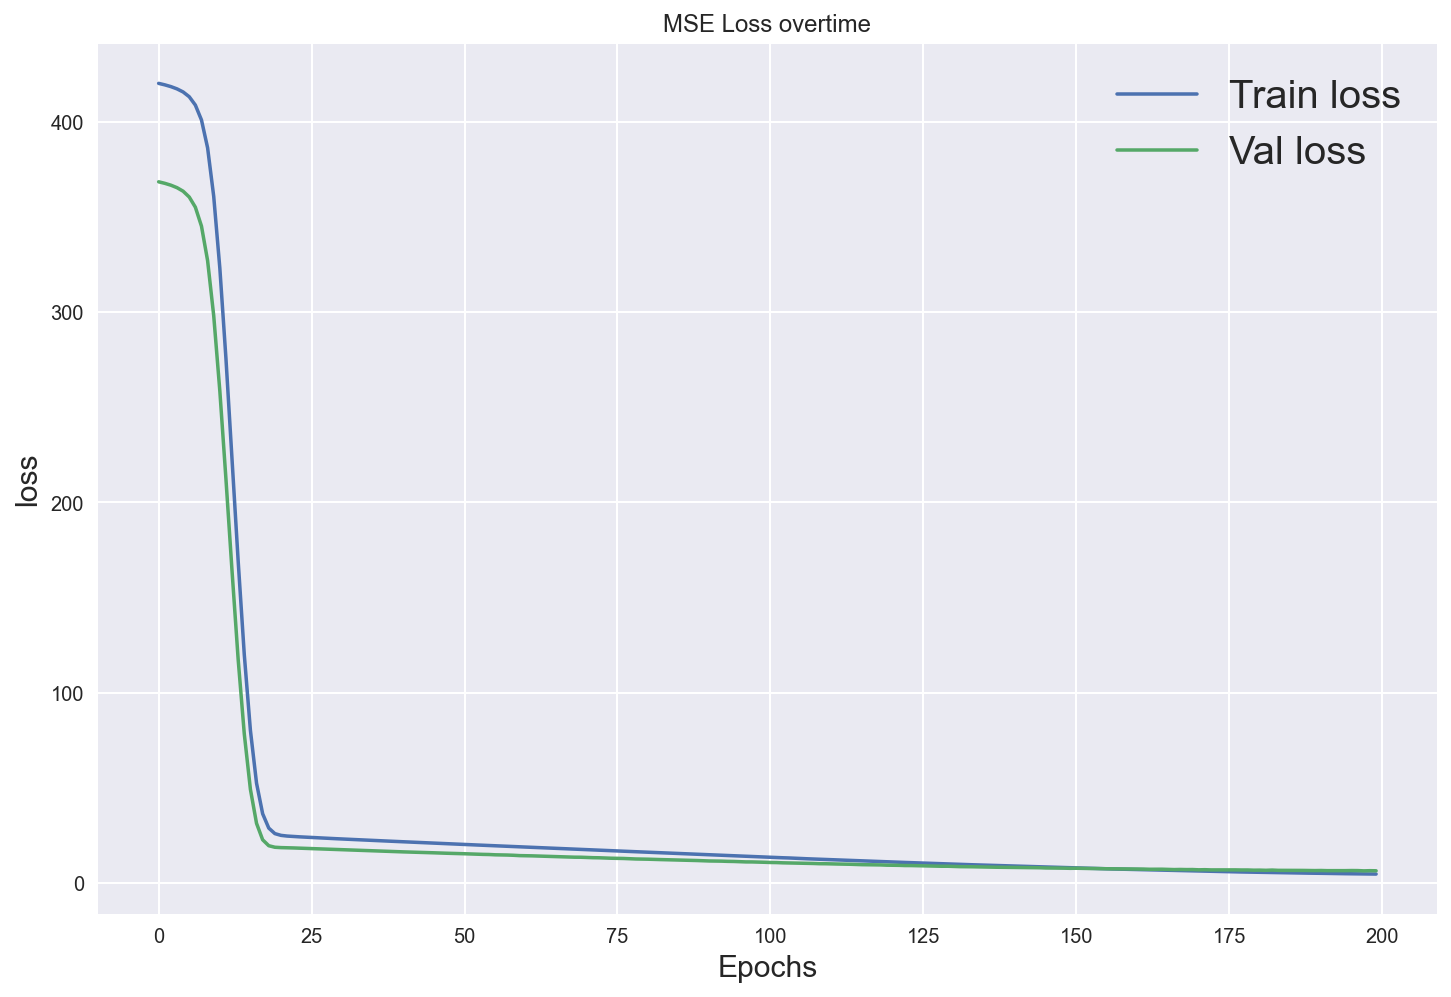

In [24]:
regr_net_mse.plot_loss()

### Regression with RMSE log loss

In [21]:
hp = HyperParameter(epochs=200)
regr_net_rmse_log = Model(hp,
                      DistanceRegrNet(input_dim=2).to(device),
                      criterion=RMSELogLoss(reduction='sum'))

regr_net_rmse_log.regr_nn.train()
regr_net_rmse_log.fit(train_data_loader, device, val_data_loader)

Avg Validation loss at epoch 0 is 7.070230484008789
Avg Train loss at epoch 0 is 14.516037181498039
Avg Validation loss at epoch 1 is 6.966318607330322
Avg Train loss at epoch 1 is 14.244026568726252
Avg Validation loss at epoch 2 is 6.8077778816223145
Avg Train loss at epoch 2 is 13.952182497054263
Avg Validation loss at epoch 3 is 6.586204528808594
Avg Train loss at epoch 3 is 13.66962657672874
Avg Validation loss at epoch 4 is 6.421616554260254
Avg Train loss at epoch 4 is 13.2489558276541
Avg Validation loss at epoch 5 is 6.201820373535156
Avg Train loss at epoch 5 is 12.836885071317754
Avg Validation loss at epoch 6 is 5.862480640411377
Avg Train loss at epoch 6 is 12.280814742363964
Avg Validation loss at epoch 7 is 5.435412883758545
Avg Train loss at epoch 7 is 11.549642703099252
Avg Validation loss at epoch 8 is 4.955480575561523
Avg Train loss at epoch 8 is 10.661197958853622
Avg Validation loss at epoch 9 is 4.435152053833008
Avg Train loss at epoch 9 is 9.684506006584863
Avg

Avg Validation loss at epoch 80 is 0.3716621696949005
Avg Train loss at epoch 80 is 0.742907366013063
Avg Validation loss at epoch 81 is 0.37441933155059814
Avg Train loss at epoch 81 is 0.7380274180928501
Avg Validation loss at epoch 82 is 0.3714902400970459
Avg Train loss at epoch 82 is 0.7316507547493366
Avg Validation loss at epoch 83 is 0.3725776672363281
Avg Train loss at epoch 83 is 0.7357930713191883
Avg Validation loss at epoch 84 is 0.3747650384902954
Avg Train loss at epoch 84 is 0.7323425184934105
Avg Validation loss at epoch 85 is 0.36774110794067383
Avg Train loss at epoch 85 is 0.7260901209060484
Avg Validation loss at epoch 86 is 0.3676269054412842
Avg Train loss at epoch 86 is 0.7241722861109
Avg Validation loss at epoch 87 is 0.3689221143722534
Avg Train loss at epoch 87 is 0.7237536729726195
Avg Validation loss at epoch 88 is 0.3672824501991272
Avg Train loss at epoch 88 is 0.7192864544119029
Avg Validation loss at epoch 89 is 0.36100777983665466
Avg Train loss at ep

Avg Validation loss at epoch 157 is 0.32916608452796936
Epoch   157: reducing learning rate of group 0 to 1.0000e-07.
Avg Train loss at epoch 157 is 0.6088348494931027
Avg Validation loss at epoch 158 is 0.3299260437488556
Avg Train loss at epoch 158 is 0.606924173730758
Avg Validation loss at epoch 159 is 0.3339524269104004
Avg Train loss at epoch 159 is 0.61085496801803
Avg Validation loss at epoch 160 is 0.3290082514286041
Avg Train loss at epoch 160 is 0.6038998213942665
Avg Validation loss at epoch 161 is 0.3266048729419708
Avg Train loss at epoch 161 is 0.605956045128879
Avg Validation loss at epoch 162 is 0.33234089612960815
Avg Train loss at epoch 162 is 0.606592593383585
Avg Validation loss at epoch 163 is 0.3271329402923584
Epoch   163: reducing learning rate of group 0 to 1.0000e-08.
Avg Train loss at epoch 163 is 0.609543812874427
Avg Validation loss at epoch 164 is 0.3279021382331848
Avg Train loss at epoch 164 is 0.6079260706959189
Avg Validation loss at epoch 165 is 0.33

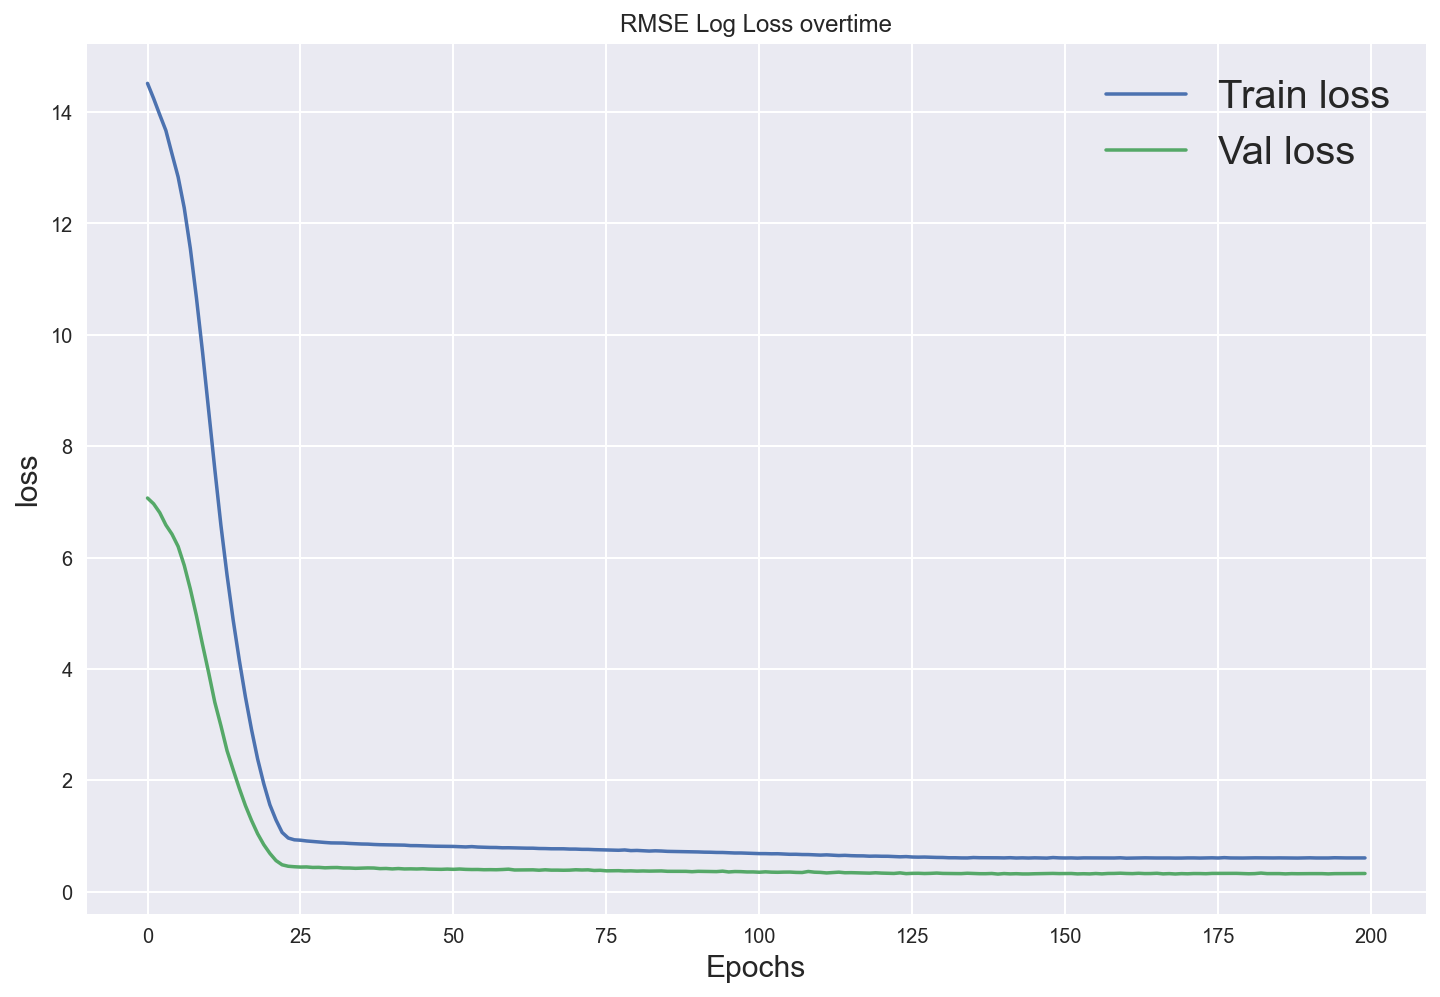

In [22]:
regr_net_rmse_log.plot_loss(title='RMSE Log Loss overtime')

### Regression with RMSE Loss

In [23]:
hp = HyperParameter(epochs=200)
regr_net_rmse = Model(hp,
                      DistanceRegrNet(input_dim=2).to(device),
                      criterion=RMSELoss(reduction='sum'))

regr_net_rmse.regr_nn.train()
regr_net_rmse.fit(train_data_loader, device, val_data_loader)

Avg Validation loss at epoch 0 is 51.569759368896484
Avg Train loss at epoch 0 is 108.16650525784682
Avg Validation loss at epoch 1 is 50.821571350097656
Avg Train loss at epoch 1 is 108.11784108292204
Avg Validation loss at epoch 2 is 50.597171783447266
Avg Train loss at epoch 2 is 107.67392097908329
Avg Validation loss at epoch 3 is 50.5556755065918
Avg Train loss at epoch 3 is 106.91709602050449
Avg Validation loss at epoch 4 is 50.14732360839844
Avg Train loss at epoch 4 is 106.67300180517904
Avg Validation loss at epoch 5 is 48.76265335083008
Avg Train loss at epoch 5 is 104.61155347100753
Avg Validation loss at epoch 6 is 46.77893829345703
Avg Train loss at epoch 6 is 102.38721761700292
Avg Validation loss at epoch 7 is 43.72955322265625
Avg Train loss at epoch 7 is 97.52437653076852
Avg Validation loss at epoch 8 is 39.174705505371094
Avg Train loss at epoch 8 is 89.75324857342495
Avg Validation loss at epoch 9 is 32.8017463684082
Avg Train loss at epoch 9 is 78.91943953729469
A

Avg Validation loss at epoch 81 is 6.665257930755615
Avg Train loss at epoch 81 is 14.402863346520553
Avg Validation loss at epoch 82 is 6.68015193939209
Avg Train loss at epoch 82 is 14.086428258337584
Avg Validation loss at epoch 83 is 6.763433456420898
Avg Train loss at epoch 83 is 14.13679663229076
Avg Validation loss at epoch 84 is 6.711190700531006
Avg Train loss at epoch 84 is 13.977213564004657
Avg Validation loss at epoch 85 is 6.730352401733398
Avg Train loss at epoch 85 is 14.10812707136275
Avg Validation loss at epoch 86 is 6.718229293823242
Avg Train loss at epoch 86 is 13.714013515347537
Avg Validation loss at epoch 87 is 6.5558390617370605
Avg Train loss at epoch 87 is 13.565085575203158
Avg Validation loss at epoch 88 is 6.504444599151611
Avg Train loss at epoch 88 is 13.444914614687125
Avg Validation loss at epoch 89 is 6.517836570739746
Avg Train loss at epoch 89 is 13.418707112347949
Avg Validation loss at epoch 90 is 6.595995903015137
Avg Train loss at epoch 90 is 1

Avg Validation loss at epoch 158 is 6.020428657531738
Avg Train loss at epoch 158 is 11.261513635671381
Avg Validation loss at epoch 159 is 5.878416538238525
Avg Train loss at epoch 159 is 11.250638608666305
Avg Validation loss at epoch 160 is 6.046349048614502
Avg Train loss at epoch 160 is 11.299133055165958
Avg Validation loss at epoch 161 is 6.156831741333008
Avg Train loss at epoch 161 is 11.313993167655896
Avg Validation loss at epoch 162 is 5.834506988525391
Avg Train loss at epoch 162 is 11.219886883018738
Avg Validation loss at epoch 163 is 5.892704963684082
Avg Train loss at epoch 163 is 11.280755734882113
Avg Validation loss at epoch 164 is 5.9341816902160645
Avg Train loss at epoch 164 is 11.099281346178847
Avg Validation loss at epoch 165 is 6.081295490264893
Avg Train loss at epoch 165 is 11.309425833073375
Avg Validation loss at epoch 166 is 6.135838031768799
Avg Train loss at epoch 166 is 11.219226170603173
Avg Validation loss at epoch 167 is 5.894101619720459
Avg Train

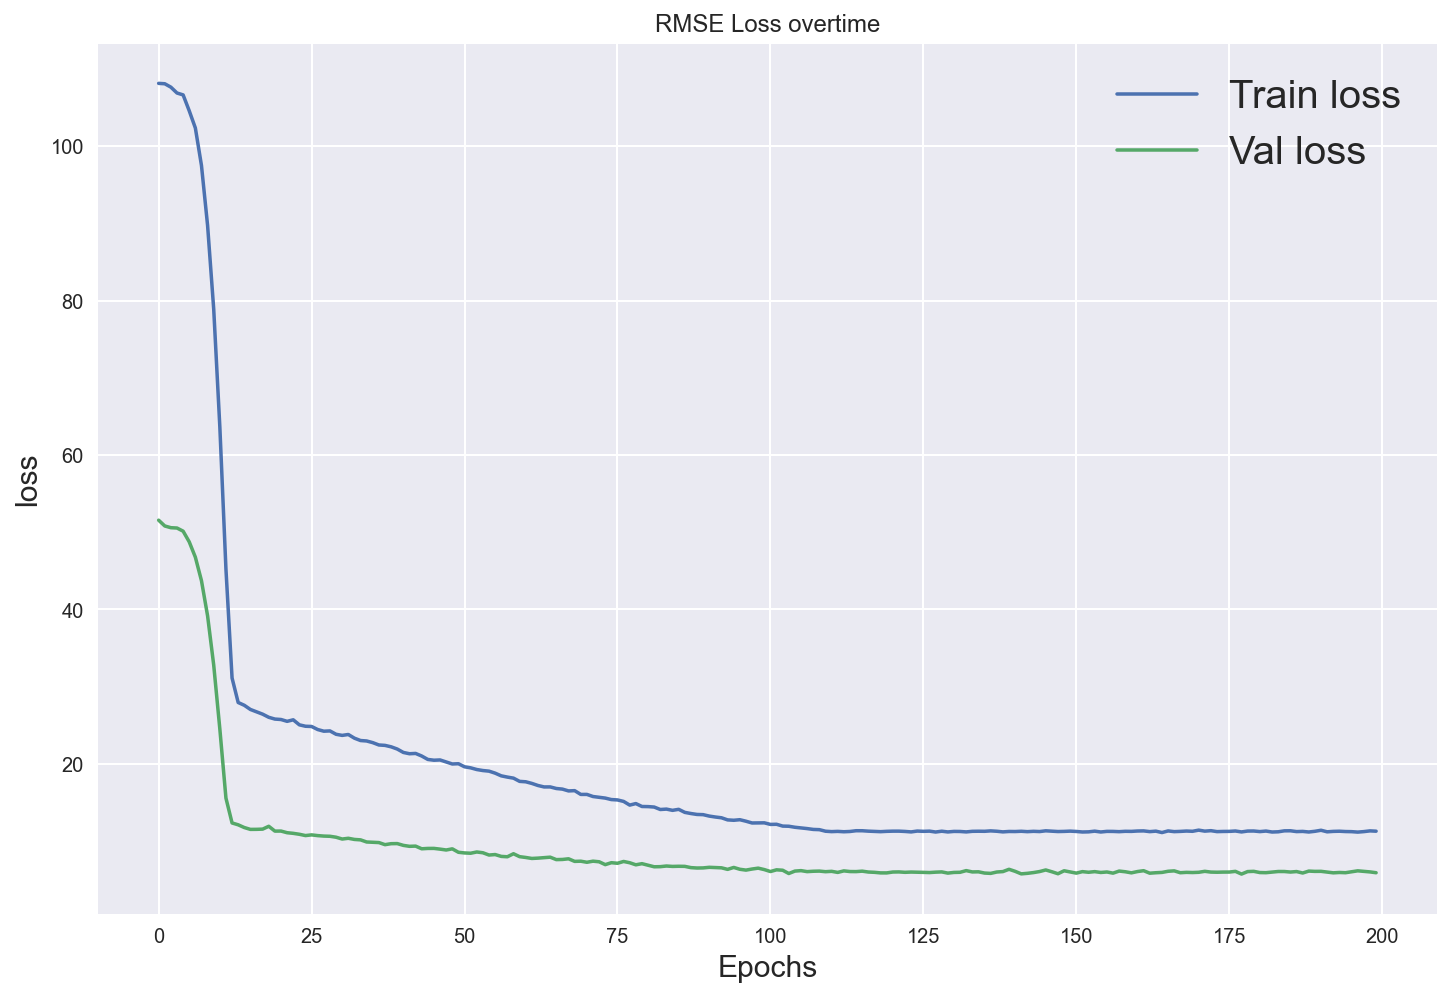

In [24]:
regr_net_rmse.plot_loss(title='RMSE Loss overtime')

## Evaluation of Regression Model based on different metrics 

In [25]:
regr_net_mse.regr_nn.eval()
y_pred = regr_net_mse.predict(torch.Tensor(X_train_scaler.transform(X_val)))
print("mse_loss, rmse_loss, rmse_log_loss, sqr_rel_diff, abs_rel_diff Losses")
calculate_loss_across_all_metrics(y_pred, torch.Tensor(y_val))

mse_loss, rmse_loss, rmse_log_loss, sqr_rel_diff, abs_rel_diff Losses


(tensor(6.2641, grad_fn=<MseLossBackward>),
 tensor(2.5028, grad_fn=<SqrtBackward>),
 tensor(0.1264, grad_fn=<SqrtBackward>),
 tensor(0.3955, grad_fn=<DivBackward0>),
 tensor(0.0796, grad_fn=<DivBackward0>))

In [26]:
regr_net_rmse.regr_nn.eval()
y_pred = regr_net_rmse.predict(torch.Tensor(X_train_scaler.transform(X_val)))
print("mse_loss, rmse_loss, rmse_log_loss, sqr_rel_diff, abs_rel_diff Losses")
calculate_loss_across_all_metrics(y_pred, torch.Tensor(y_val))

mse_loss, rmse_loss, rmse_log_loss, sqr_rel_diff, abs_rel_diff Losses


(tensor(6.1067, grad_fn=<MseLossBackward>),
 tensor(2.4712, grad_fn=<SqrtBackward>),
 tensor(0.1177, grad_fn=<SqrtBackward>),
 tensor(0.3798, grad_fn=<DivBackward0>),
 tensor(0.0774, grad_fn=<DivBackward0>))

In [27]:
regr_net_rmse_log.regr_nn.eval()
y_pred = regr_net_rmse_log.predict(torch.Tensor(X_train_scaler.transform(X_val)))
print("mse_loss, rmse_loss, rmse_log_loss, sqr_rel_diff, abs_rel_diff Losses")
calculate_loss_across_all_metrics(y_pred, torch.Tensor(y_val))

mse_loss, rmse_loss, rmse_log_loss, sqr_rel_diff, abs_rel_diff Losses


(tensor(10.0300, grad_fn=<MseLossBackward>),
 tensor(3.1670, grad_fn=<SqrtBackward>),
 tensor(0.1243, grad_fn=<SqrtBackward>),
 tensor(0.3541, grad_fn=<DivBackward0>),
 tensor(0.0824, grad_fn=<DivBackward0>))

### Support Vector Regressor

In [28]:
from sklearn.svm import SVR

svr_regr = SVR(C=1.0, epsilon=0.2)
svr_regr.fit(X_train_scaler.transform(X_train), y_train.ravel())

SVR(epsilon=0.2)

In [29]:
calculate_loss_across_all_metrics(torch.Tensor(svr_regr.predict(X_train_scaler.transform(X_val)).reshape(-1,1)), 
                                  torch.Tensor(y_val))

(tensor(7.0425),
 tensor(2.6538),
 tensor(0.1217),
 tensor(0.3215),
 tensor(0.0782))

# Testing networks

**Prediction on actual values**

## MSE Trained

In [30]:
bbox_w = data_k['xmax'] - data_k['xmin']
bbox_h = data_k['ymax'] - data_k['ymin']
dt_point = X_train_scaler.transform(np.array([bbox_w[0], bbox_h[0]]))
print("Predicted", regr_net_mse.predict(torch.Tensor(dt_point).to(device)))
print("Actual", data_k[['zloc']].iloc[0])

Predicted tensor([7.9397], grad_fn=<SoftplusBackward>)
Actual zloc    8.41
Name: 0, dtype: float64


## RMSE Trained

In [31]:
bbox_w = data_k['xmax'] - data_k['xmin']
bbox_h = data_k['ymax'] - data_k['ymin']
dt_point = X_train_scaler.transform(np.array([bbox_w[0], bbox_h[0]]))
print("Predicted", regr_net_rmse.predict(torch.Tensor(dt_point).to(device)))
print("Actual", data_k[['zloc']].iloc[0])

Predicted tensor([7.7106], grad_fn=<SoftplusBackward>)
Actual zloc    8.41
Name: 0, dtype: float64


## RMSE Log Trained

In [32]:
bbox_w = data_k['xmax'] - data_k['xmin']
bbox_h = data_k['ymax'] - data_k['ymin']
dt_point = X_train_scaler.transform(np.array([bbox_w[0], bbox_h[0]]))
print("Predicted", regr_net_rmse_log.predict(torch.Tensor(dt_point).to(device)))
print("Actual", data_k[['zloc']].iloc[0])

Predicted tensor([7.9911], grad_fn=<SoftplusBackward>)
Actual zloc    8.41
Name: 0, dtype: float64


## SVR Trained

In [33]:
bbox_w = data_k['xmax'] - data_k['xmin']
bbox_h = data_k['ymax'] - data_k['ymin']
dt_point = X_train_scaler.transform(np.array([bbox_w[0], bbox_h[0]]))
print("Predicted", svr_regr.predict(dt_point.reshape(1,-1)))
print("Actual", data_k[['zloc']].iloc[0])

Predicted [8.10861263]
Actual zloc    8.41
Name: 0, dtype: float64


## Regression performance at different distances

In [34]:
def plot_loss_over_dist(start_dist,
                        metric_overtime,
                        label='Error',
                        title='Erro overtime'):
    plt.figure(figsize=(9, 7))
    plt.title(title)
    plt.grid(axis='x')
    plt.ylabel('Error (m)', fontsize=20)
    plt.xlabel('Distances (m)', fontsize=20)
    plt.xticks(np.arange(0, max(start_dist)+1, 5.0))
    plt.yticks(fontsize=20)
    plt.legend(fontsize=22)

    plt.plot(start_dist, metric_overtime, label=label)
    plt.show()


def compare_loss_over_dist(dist1,
                           metric1,
                           label1,
                           dist2=None,
                           metric2=None,
                           label2=None,
                           title='Error overtime'):

    plt.figure(figsize=(9, 7))
    plt.title(title)
    plt.grid(axis='x')
    plt.ylabel('Error (m)', fontsize=20)
    plt.xlabel('Distances (m)', fontsize=20)
    
    plt.plot(dist1, metric1, label=label1)
    plt.plot(dist2, metric2, label=label2)
    plt.xticks(np.arange(0, max(dist1)+1, 5.0), fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=22)
    plt.show()


def regression_metrics_at_different_dist_levels(model, X, y, metric, step=1):
    vmax, vmin = int(np.max(y)), int(np.min(y))
    metric_overtime = []
    start_dist = []
    for d in range(vmin, vmax, step):
        filter_idx = np.argwhere(np.logical_and(y < d+step, y >= d))[:, 0]
        X_filter = np.take(X, filter_idx, axis=0)
        y_filter = np.take(y, filter_idx, axis=0)
        y_pred = model(X_filter).reshape(-1, 1)
        start_dist.append(d)
        metric_overtime.append(metric(torch.Tensor(y_pred).to('cpu'),
                                      torch.Tensor(y_filter).to('cpu')))
    return start_dist, metric_overtime

In [35]:
d1, m1 = regression_metrics_at_different_dist_levels(regr_net_mse.predict,
                                                     torch.Tensor(
                                                         X_train_scaler.transform(X_feat)),
                                                     y_feat,
                                                     nn.MSELoss())

In [36]:
d2, m2 = regression_metrics_at_different_dist_levels(svr_regr.predict,
                                                     X_train_scaler.transform(
                                                         X_feat),
                                                     y_feat,
                                                     nn.MSELoss())

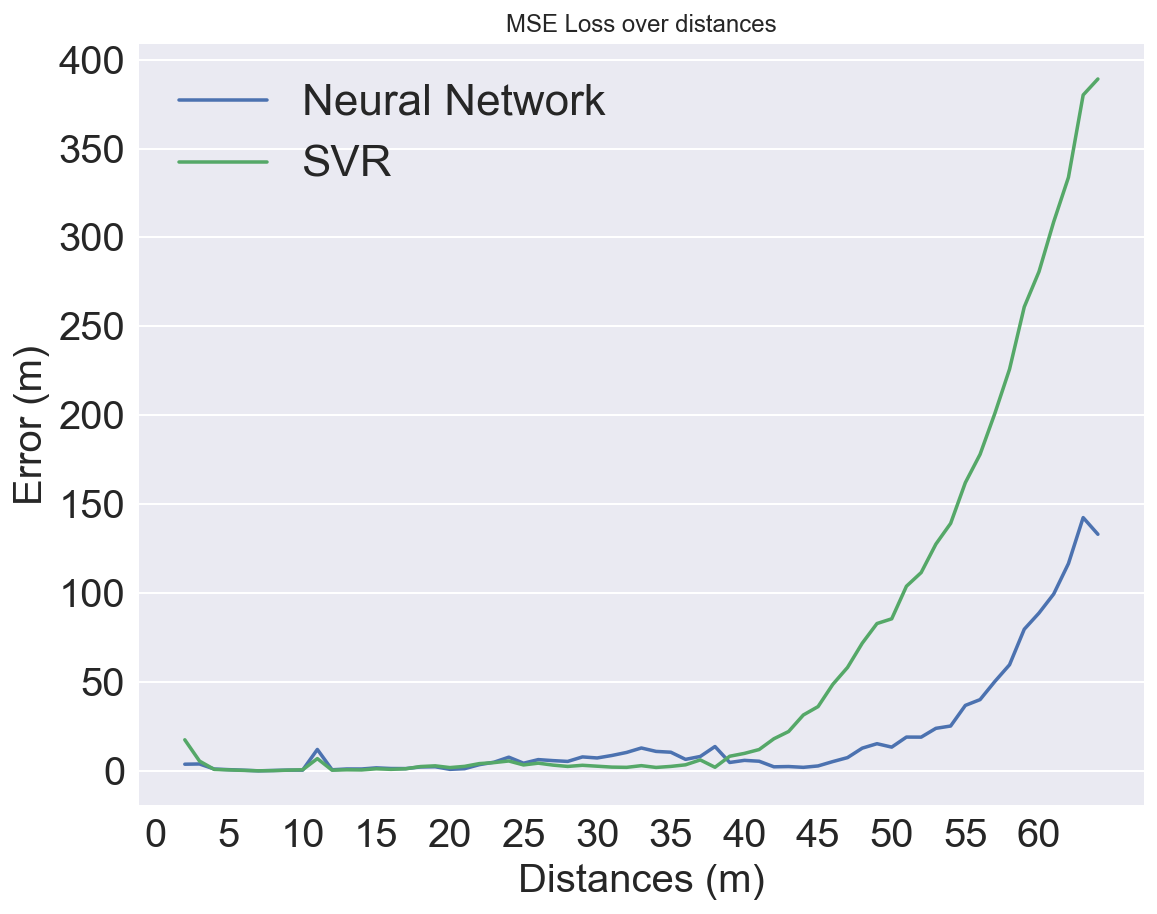

In [37]:
end = -8
compare_loss_over_dist(d1[:end], m1[:end], 'Neural Network',
                       d2[:end], m2[:end], 'SVR', "MSE Loss over distances")

No handles with labels found to put in legend.


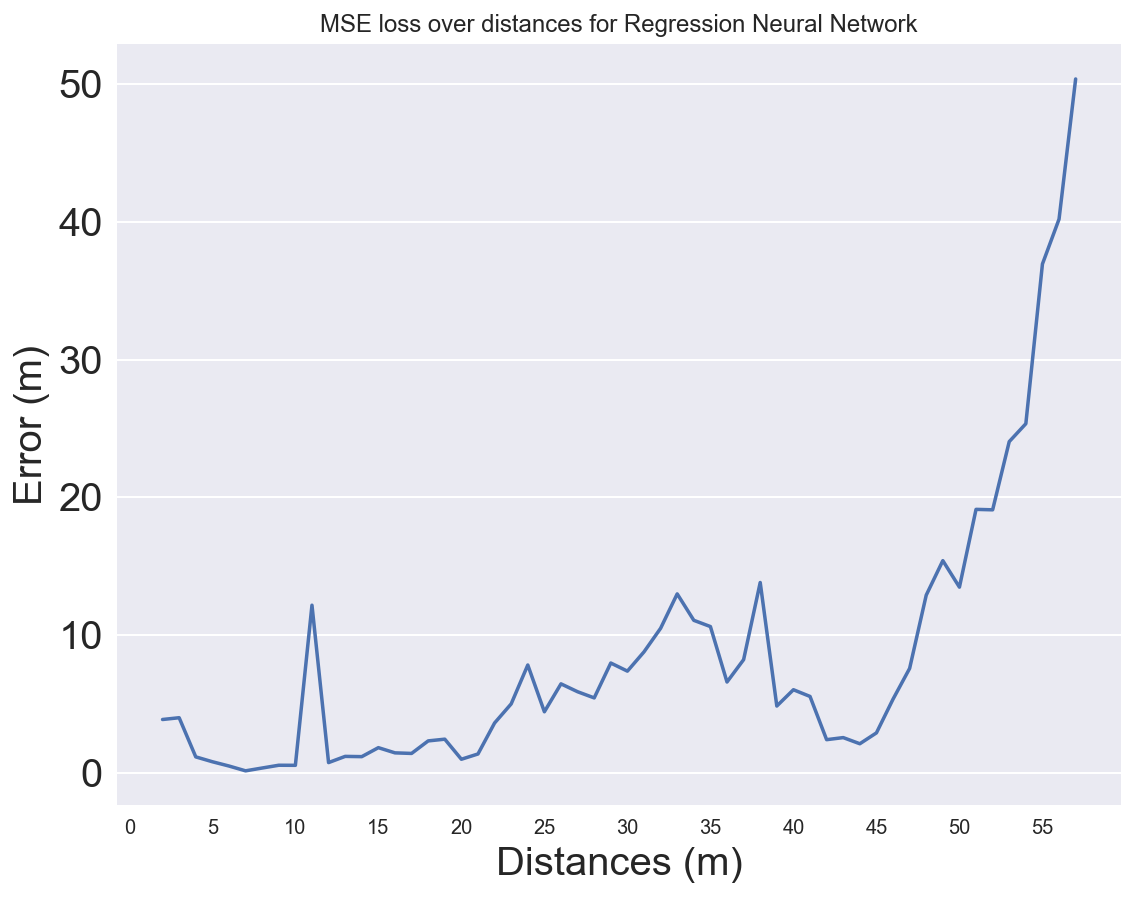

No handles with labels found to put in legend.


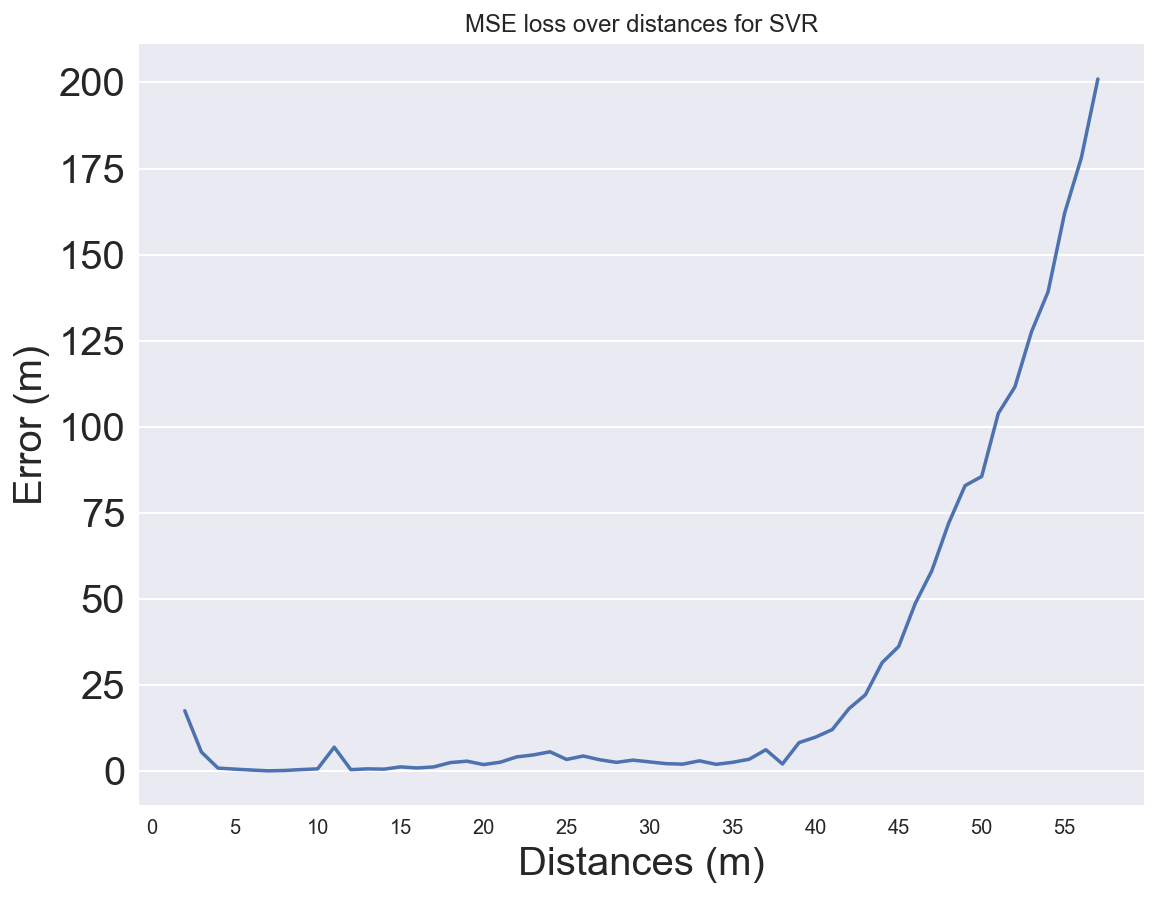

In [38]:
end = -15
plot_loss_over_dist(d1[:end], m1[:end], label='Neural Network', title='MSE loss over distances for Regression Neural Network')
plot_loss_over_dist(d2[:end], m2[:end], label='SVR', title='MSE loss over distances for SVR')

## Experiment with ground truth and predicted distance

## The following values were generated by the program SSD_active_crowd_analysis/demo_scene_crowd_video.py using the videos in https://drive.google.com/drive/folders/1hxoNDtZJtkIaoN89uM8H4nrJdJIEQnWh?usp=sharing

The values can be generated for any video for a person walking towards the camera as per the instructions in README.md

In [5]:
# dist_pred_arr = np.array([
#     [6.7374907, 6.730349, 6.3290906, 6.3946576, 6.4590693, 5.8892055, 5.8552084, 5.9148946, 5.971723, 5.7510533, 5.571766, 5.4313397, 5.733493, 5.390663, 5.2275662, 4.9655766, 5.208589, 5.3485394, 5.220836, 5.18264, 4.9162717, 5.0812106, 5.3249483, 5.9166865, 6.3258834, 5.5330024, 5.2244344, 4.645189, 5.05, 4.7913465, 5.0219064, 4.6265597, 4.801665, 4.0167, 4.010919, 4.674851, 4.4702725, 4.2766676, 4.290838, 4.4866447, 3.7941797, 4.131687, 3.8643794, 2.8904176, 2.772292, 2.697421, 2.6482043, 2.9276307, 3.043971, 2.9620028, 2.9877734, 3.0791817, 2.5464025, 2.8761427, 3.0749922, 3.0215757, 2.9463246, 2.9963171, 3.2312737, 3.1176274, 2.983654, 3.023727, 2.7325287, 2.712256, 2.8843052, 1.0840483, 1.1056595, 0.9779581, 0.9583523, 0.9635239, 1.0109676, 0.9289655, 1.01354, 0.9937702, 1.1589417, 1.1654328, 1.2535784, 1.3623999, 1.4938315, 1.2841454, 1.292542, 1.3895309, 1.2215977, 1.2707431, 0.9482724, 0.8802993, 0.6886582, 0.7331899, 0.563939, 0.6559468, 0.70600736, 0.44377866, 0.44392198, 0.58373857, 0.44334155, 0.49525768, 0.6153863, 0.5993582, 0.6227413, 0.8372942, 0.79319394, 0.53597, 0.67608625, 0.49364978, 0.4439509, 0.43977386, 0.4413353, 0.43754548, 0.43672958, 0.43920654, 0.43774736, 0.43762437, 0.43663642, 0.43733495, 0.4356972, 0.43499652, 0.43627268, 0.43500367, 0.43378237, 0.43100503, 0.42776045, 0.4268631, 0.42637888, 0.4242469, 0.4323816, 0.4309463, 0.42902938, 0.42932808, 0.42936578, 0.42844096, 0.4280685, 0.42881435, 0.42125204, 0.42712593, 0.41764033, 0.4273514, 0.42174605, 0.41864613, 0.41865328, 0.41877997, 0.42445424, 0.42149493, 0.4220837, 0.41980034, 0.41969374, 0.42022553, 0.41794086, 0.4171098, 0.41657928, 0.416881, 0.41960874, 0.42108935, 0.41425657, 0.41264766, 0.41262707, 0.41295448, 0.41032654, 0.41082582, 0.41898534, 0.41579068, 0.41188306, 0.40949547, 0.4074086, 0.4031119, 0.3978434, 0.4011628],
#     [6.1874557, 6.008411, 6.1863194, 6.213607, 6.0098433, 5.863656, 5.905373, 5.5732894, 5.2657795, 5.4888153, 5.7999744, 5.467677, 5.392763, 5.394693, 5.612526, 5.769941, 5.621234, 5.587363, 5.2282276, 5.274711, 5.2654815, 5.2931056, 4.848842, 5.1414347, 4.489151, 4.4137974, 4.283277, 4.078849, 4.1804004, 4.621712, 4.690219, 5.076401, 4.891834, 4.365146, 4.333046, 3.7955253, 3.2687392, 3.162862, 3.247981, 3.2993174, 4.3466473, 3.213542, 2.9785168, 2.7031274, 2.915346, 3.8872497, 3.373175, 3.5918016, 3.5222478, 3.12295, 3.1231728, 3.0021157, 2.9335394, 2.9040532, 2.580193, 2.8520103, 2.4904187, 2.7430987, 2.6854267, 2.1226804, 2.1973588, 2.420122, 2.0518909, 2.6573043, 2.6885164, 2.6093643, 2.6670327, 2.6865308, 2.5603013, 2.5910437, 2.6640713, 2.5816052, 2.7257361, 2.7971473, 2.5741653, 2.731476, 2.6805503, 1.5782537, 1.5503583, 1.4505467, 1.4095746, 1.4220109, 1.2922236, 1.4260594, 1.5092378, 1.4264717, 1.359139, 1.2084291, 1.1616117, 1.154293, 1.1092331, 1.0578852, 0.94938034, 0.870822, 0.8649094, 0.6706508, 0.9114359, 0.6734768, 0.68878484, 0.8044887, 0.804082, 0.9147384, 0.8634567, 0.75682604, 0.79736567, 0.6820266, 0.59527695, 0.48413414, 0.4455768, 0.44404876, 0.44583875, 0.47775087, 0.5926496, 0.65753025, 0.67137945, 0.67088217, 0.63934183, 0.76207125, 0.601798, 0.5764274, 0.575661, 0.54253566, 0.4427757, 0.44219062, 0.4364977, 0.43955562, 0.43884718, 0.4344164, 0.43556345, 0.44069812, 0.4360086, 0.44149303, 0.43968597, 0.42912036, 0.4307397, 0.43044102, 0.43002614, 0.43059233, 0.42716458, 0.43260515, 0.4293691, 0.42772228, 0.42761233, 0.4254424, 0.4226775, 0.42172444, 0.4192226, 0.41756496, 0.41731414, 0.41614592, 0.41654566, 0.41561556, 0.4160868, 0.41627714, 0.41787437, 0.41791263, 0.4252629, 0.4244586, 0.42533863, 0.42369917, 0.42145923, 0.42007625, 0.41970792, 0.41798767, 0.41703945, 0.41768444, 0.41664046, 0.41505116, 0.41398343, 0.4127486, 0.41819775, 0.4189543, 0.41801795, 0.4129367, 0.4174988, 0.41556308, 0.4110902, 0.41336787, 0.41452727, 0.4152894, 0.4161167, 0.41485554, 0.41574326, 0.413914, 0.4144511, 0.41296554, 0.41253826, 0.4062112, 0.41038918, 0.40837663, 0.4039688],
#     [6.6245804, 6.7680445, 6.5028424, 7.0008693, 7.0851564, 7.1923175, 6.9831786, 7.1454325, 6.893819, 6.999356, 7.2029886, 6.9320803, 7.030475, 6.645102, 6.179728, 6.1657467, 6.4017477, 6.3484254, 6.1521425, 5.8964324, 5.677261, 5.5136747, 5.5401287, 5.915005, 4.6461277, 5.115953, 4.651641, 4.183789, 3.959295, 4.083387, 3.8997335, 3.8393798, 4.50136, 3.5735943, 3.0955696, 3.5876498, 4.218451, 4.2713547, 3.7639818, 4.055193, 3.637469, 4.037812, 3.4431982, 2.952274, 2.9345913, 2.8820846, 2.7755795, 2.6380687, 2.8009193, 2.7246208, 2.5340416, 2.646326, 3.0208297, 2.4522872, 1.9795437, 1.9880271, 2.0014853, 2.0428526, 2.0027812, 1.9228141, 1.8416061, 1.889111, 1.8164468, 2.5955627, 2.76494, 2.6545868, 1.6939454, 1.7604266, 1.5360516, 1.550607, 1.5104288, 1.3789145, 1.1232808, 1.0610437, 1.0005487, 1.0185964, 0.9605858, 0.93423206, 0.7756832, 0.8589833, 0.8243388, 0.79420674, 0.6087204, 0.5209178, 0.55126697, 0.55249625, 0.5768497, 0.49624848, 0.5216699, 0.58221835, 0.4798775, 0.6045951, 0.749426, 0.72960824, 0.5618672, 0.6656872, 0.67900836, 0.70814973, 0.7129362, 0.67683375, 0.48476484, 0.49770933, 0.56884885, 0.582629, 0.4446181, 0.44143435, 0.43956703, 0.44100726, 0.44230622, 0.46728018, 0.45156854, 0.4587141, 0.4445926, 0.44348505, 0.44223368, 0.4405338, 0.43960384, 0.43546635, 0.43277383, 0.43041775, 0.42955273, 0.42993778, 0.4278799, 0.42857885, 0.43004417, 0.42644092, 0.42608303, 0.42280188, 0.42518446, 0.42690668, 0.42511842, 0.42266005, 0.4260653, 0.42785433, 0.41721147, 0.41770238, 0.42396128, 0.42289585, 0.42191535, 0.41927388, 0.42064083, 0.4194475, 0.41782007, 0.41984674, 0.41518208, 0.41434312, 0.4153974, 0.41511658, 0.41068992, 0.41503254, 0.4132525, 0.40810224, 0.40842354, 0.4086415, 0.41224697, 0.40651777, 0.40492016, 0.4105046, 0.40988207, 0.40833652, 0.40446463, 0.4096129, 0.40738717, 0.4077919, 0.40667734, 0.40683123, 0.40508997, 0.40365228, 0.39967692, 0.39906126, 0.39757496, 0.39548126, 0.395386, 0.39365026, 0.39276832, 0.3925175, 0.39277536, 0.39333248, 0.3945037, 0.39463302, 0.39473787, 0.39479092, 0.3930495, 0.39363363, 0.39351743, 0.39312613, 0.39364865, 0.3931681],
#     [6.370936, 6.053892, 6.5171547, 6.3715253, 6.4404263, 6.662978, 6.348994, 6.266365, 6.2689996, 6.7540665, 6.4977517, 5.8993177, 5.698193, 5.82866, 5.61157, 5.6554923, 5.674802, 5.606173, 5.5335, 5.7390637, 5.7019796, 5.319398, 5.120848, 5.158806, 4.982983, 4.98034, 4.6904125, 3.3315122, 3.5244808, 3.6167278, 4.109388, 4.2480316, 3.3880181, 2.9452407, 3.6899128, 3.1841502, 3.0885496, 2.996467, 2.857809, 2.7326362, 2.5687878, 2.3921044, 2.416107, 2.8977635, 3.035286, 3.04792, 3.1218286, 3.0823767, 3.1413953, 2.870161, 2.818725, 2.7908895, 2.6124814, 2.4702246, 2.4987712, 2.5480509, 2.5605087, 2.5337594, 2.5006597, 2.5455894, 2.5138092, 2.4871006, 2.3597162, 2.5219705, 2.4366035, 2.5907428, 1.7400216, 1.8051608, 1.6202424, 1.5639858, 1.4623309, 1.1738788, 1.2954977, 1.2567564, 1.1852379, 1.1325576, 1.1268291, 1.1526589, 1.1564696, 1.0152502, 1.2177539, 0.9827047, 0.9550261, 1.0236362, 1.0353135, 0.8912266, 0.796893, 0.81825423, 0.72403985, 0.7425224, 0.5447338, 0.54705447, 0.48107958, 0.4605599, 0.4772303, 0.44557086, 0.61218184, 0.44648942, 0.44712123, 0.5740348, 0.45013183, 0.44573662, 0.45720086, 0.47935176, 0.514773, 0.44613308, 0.4464837, 0.4838914, 0.4445566, 0.57238746, 0.442997, 0.4423468, 0.44292766, 0.47175357, 0.5022595, 0.48991293, 0.44940278, 0.4444292, 0.4451778, 0.442323, 0.44275934, 0.4430072, 0.44242486, 0.44434357, 0.43976304, 0.43997434, 0.43915668, 0.43962348, 0.4368267, 0.43657464, 0.4354621, 0.43445438, 0.43337515, 0.4330659, 0.43270937, 0.4332485, 0.4328988, 0.43523526, 0.4312072, 0.43262807, 0.43174195, 0.4295356, 0.42896032, 0.42976135, 0.42916167, 0.4280954, 0.4237179, 0.42289752, 0.4273336, 0.42729834, 0.42719942, 0.42867178, 0.4291377, 0.43040687, 0.42887658, 0.42703497, 0.42668682, 0.42470333, 0.42284164, 0.4227453, 0.4229393, 0.42182577, 0.41955414, 0.41858962, 0.4187324, 0.41793576, 0.41817603, 0.4220479, 0.41694194, 0.41436446, 0.41404623, 0.41207075, 0.41107213, 0.40738985, 0.40548497, 0.40037367, 0.39720652],
# ])

dist_pred_arr = np.load('./SSD_active_crowd_analysis/distance_regressor/data/pred_dist.npy', allow_pickle=True)
MAX_SEQ = 100
dist_pred_arr = [arr[:MAX_SEQ] for arr in dist_pred_arr]

### The Individual was walking towards the camera starting at a distance of 7 m coming to a stop infront of the camera at 0.4 m

If we look at the diagram below and the videos used to generate the values in dist_pred_arr,
the person arrives at 0.4 m in front of the camera at approximately 100 frames after starting,
so speed is 6.6/100 = 0.066 meters per frame

Therefore the slope of the ground truth line should be as close to 0.066 as possible

In [6]:
# Ground truth is set to decrease from 6.8m to 0.5m
gt_START = 7
gt_END = 0.4
gt_TIME = 100

dist_gt = np.linspace(7, 0.4, gt_TIME)
print(f"Magnitude of slope of GT line is {round(abs((gt_END-gt_START)/ gt_TIME), 4)}")
print(f"Slope should be close to {round(abs((gt_END-gt_START)/ 100), 4)}")

Magnitude of slope of GT line is 0.066
Slope should be close to 0.066


In [7]:
def plot_pred_vs_real_dist(dist_pred_arr, dist_gt):
    pred_arr_np = np.array([np.array(arr) for arr in dist_pred_arr])
    dist_avg = [(sum(pred_arr_np[:,i]))/(pred_arr_np.shape[0]) 
                for i in range(pred_arr_np.shape[1])]
    plt.figure(figsize=(12, 8))
    for pred in dist_pred_arr:
        plt.plot(pred, c='#5ac9ff', alpha=0.20)
    plt.plot(dist_pred_arr[0], c='#5ac9ff', label='Individual Tests', alpha=0.20)
    plt.plot(dist_avg, c='#0d89c5', label='Averaged Pred')
    plt.plot(dist_gt, c='green', label='Grouth Truth')
    
    plt.ylabel("Distance (m)", fontsize=22)
    plt.xlabel('Time (frames)', fontsize=22)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=22)
    plt.show()

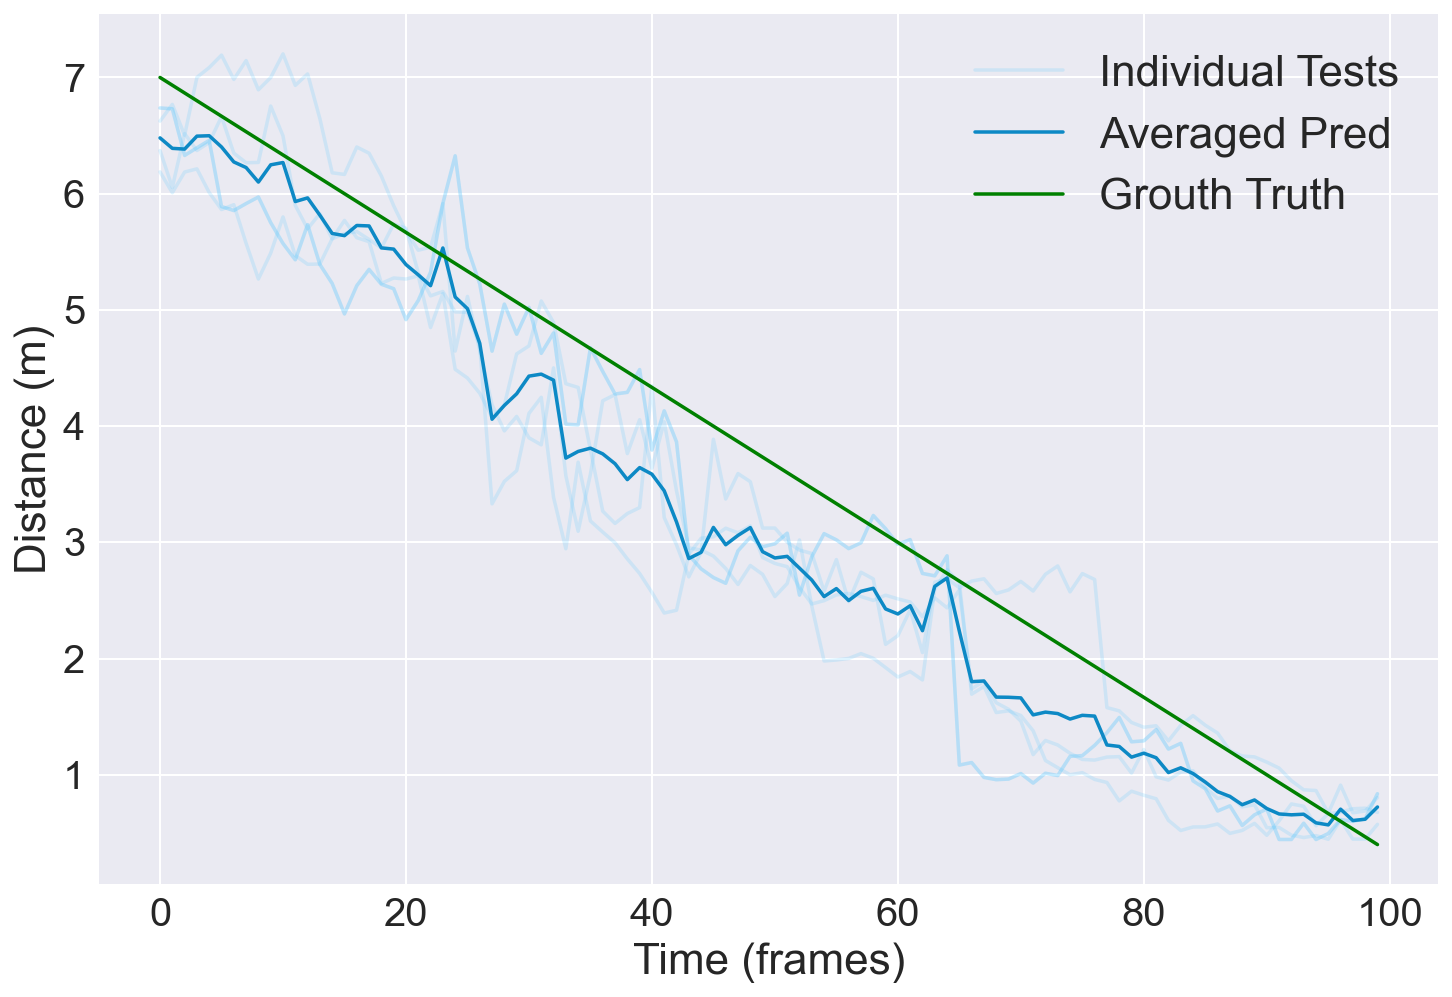

In [8]:
plot_pred_vs_real_dist(dist_pred_arr, dist_gt)

**Time was set to an arbitrary axis since the original frame rate for the source videos was set to 10 fps so we cannot use seconds anymore so we use frames instead**
